# Control teórico Ball and Beam

In [432]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

In [433]:
# Parámetros fisicos
m = 0.005       # masa bola [kg]
g = 9.81      # gravedad [m/s^2]
d = 0.05      # distancia eje a haz [m]
L = 0.4       # longitud del haz [m]
J = 9.99e-6     # momento de inercia de la bola [kg*m^2]
Radio = 0.03     # radio de la bola [m]

In [434]:
k = -(m * g * d) / (L * (J / Radio**2 + m))
P = ctrl.TransferFunction([k], [1, 0, 0])  # k/s^2

print("Función de transferencia del sistema:")
print(P)

Función de transferencia del sistema:
<TransferFunction>: sys[1640]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -0.3808
  -------
    s^2


In [435]:
wn = 1
zeta = 0.707

p1 = complex(-zeta*wn, wn*np.sqrt(1-zeta**2))
p2 = np.conj(p1)
p3 = -1
desired_poles = [p1, p2, p3]

print("Polos deseados:")
for pole in desired_poles:
    print(pole)

Polos deseados:
(-0.707+0.7072135462503529j)
(-0.707-0.7072135462503529j)
-1


In [436]:
# Minimizacion ITAE

wn = 3
a = 1.75 * wn
b = 2.15 * wn**2
c = wn**3

s = ctrl.TransferFunction.s
T = wn**3/(s**3 + a*s**2 + b*s + c)

print("Función de transferencia lazo cerrado:")
print(T)


Gur = ctrl.minreal(T/P)

print("Gur:")
print(Gur)

Función de transferencia lazo cerrado:
<TransferFunction>: sys[1657]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

               27
  -----------------------------
  s^3 + 5.25 s^2 + 19.35 s + 27
0 states have been removed from the model
Gur:
<TransferFunction>: sys[1659]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

            -70.9 s^2
  -----------------------------
  s^3 + 5.25 s^2 + 19.35 s + 27


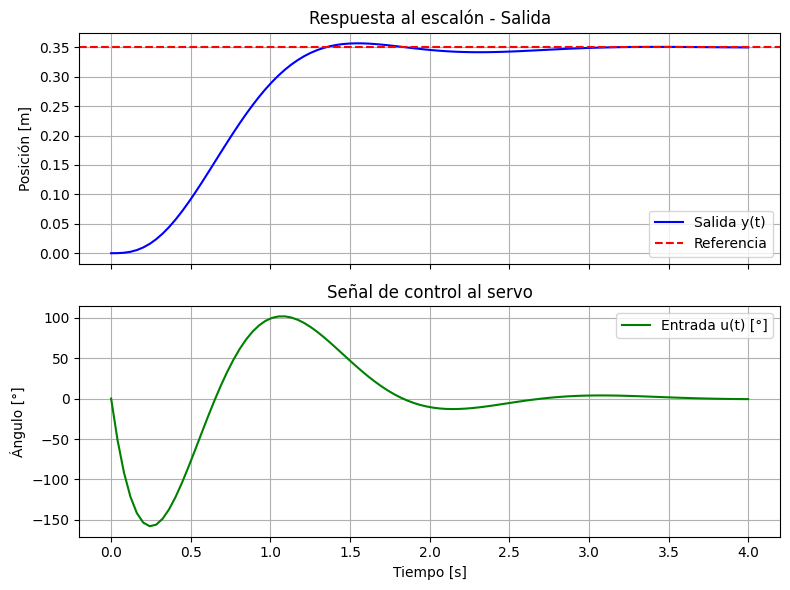

In [437]:
t = np.linspace(0, 4, 100)
dist = 0.35

t, y = ctrl.step_response(dist*T, T=t)
t, u = ctrl.step_response(dist*Gur, T=t)

u_deg = np.rad2deg(u)



# === Crear matriz de subplots (2 filas, 1 columna) ===
fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# Subplot 1: salida de la bola
axes[0].plot(t, y, 'b', label='Salida y(t)')
axes[0].axhline(dist, color='r', linestyle='--', label='Referencia')
axes[0].set_ylabel('Posición [m]')
axes[0].set_title('Respuesta al escalón - Salida')
axes[0].legend()
axes[0].grid(True)

# Subplot 2: ángulo del servo
axes[1].plot(t, u_deg, 'g', label='Entrada u(t) [°]')
axes[1].set_xlabel('Tiempo [s]')
axes[1].set_ylabel('Ángulo [°]')
axes[1].set_title('Señal de control al servo')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [438]:
# Extraemos el controlador

C = ctrl.minreal(T/(P*(1-T)))

print("Controlador C(s):")
print(C)

4 states have been removed from the model
Controlador C(s):
<TransferFunction>: sys[1671]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

        -70.9 s
  --------------------
  s^2 + 5.25 s + 19.35


# Algebraica

In [439]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

# Parámetros fisicos
m = 0.021      # masa bola [kg]
g = 9.81      # gravedad [m/s^2]
d = 0.05      # distancia eje a haz [m]
L = 0.4       # longitud del haz [m]
J = 9.99e-6     # momento de inercia de la bola [kg*m^2]
Radio = 0.03     # radio de la bola [m]

k = -(m * g * d) / (L * (J / Radio**2 + m))
P = ctrl.TransferFunction([k], [1, 0, 0])  # k/s^2

print("Función de transferencia del sistema:")
print(P)

Función de transferencia del sistema:
<TransferFunction>: sys[1672]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -0.8022
  -------
    s^2


In [ ]:
alpha = k
n = 3

wn = 0.799
zeta = 0.95


kp = (wn**2 * (2*zeta*n + 1)) / alpha
ki = (n*wn**3) / alpha
kd = (wn*(2*zeta+n))/ alpha

# Controlador PID
C = ctrl.TransferFunction([kd, kp, ki], [1, 0])
print("Controlador PID:")
print(C)

print(kp, ki, kd)

Controlador PID:
<TransferFunction>: sys[1673]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

  -4.88 s^2 - 5.332 s - 1.908
  ---------------------------
               s
-5.3318150796563275 -1.9075165292442118 -4.880334352701326


Función de transferencia lazo cerrado:
<TransferFunction>: sys[1676]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     3.915 s^2 + 4.277 s + 1.53
  --------------------------------
  s^3 + 3.915 s^2 + 4.277 s + 1.53


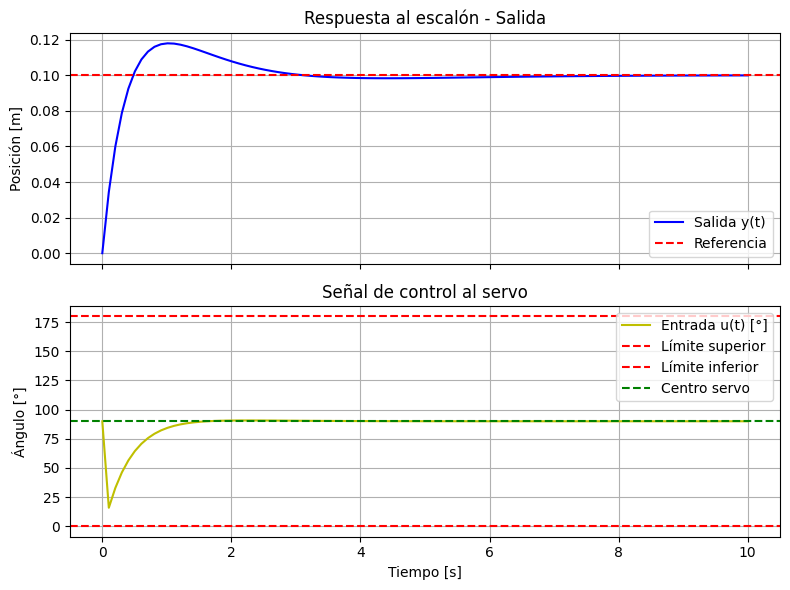

In [441]:
# Lazo cerrado
T = ctrl.feedback(C*P, 1)

print("Función de transferencia lazo cerrado:")
print(T)

# Simulación
t = np.linspace(0, 10, 100)
dist = 0.1
t, y = ctrl.step_response(dist*T, T=t)

# Ver angulo de entrada de la planta
# Calcula el error
e = dist - y

# Calcula u(t) manualmente
dt = t[1] - t[0]
integral = 0.0
u = np.zeros_like(e)

for k in range(1, len(t)):
    integral += 0.5 * (e[k] + e[k-1]) * dt     # integración trapezoidal
    derivative = (e[k] - e[k-1]) / dt          # diferencia finita
    u[k] = kp * e[k] + ki * integral + kd * derivative

u_deg = -np.rad2deg(u) + 90 # Ajuste para servo

# === Crear matriz de subplots (2 filas, 1 columna) ===
fig, axes = plt.subplots(2, 1, figsize=(8, 6),
                            sharex=True)
# Subplot 1: salida de la bola
axes[0].plot(t, y, 'b', label='Salida y(t)')
axes[0].axhline(dist, color='r', linestyle='--', label='Referencia')
axes[0].set_ylabel('Posición [m]')
axes[0].set_title('Respuesta al escalón - Salida')
axes[0].legend()
axes[0].grid(True)
# Subplot 2: ángulo del servo
axes[1].plot(t, u_deg, 'y', label='Entrada u(t) [°]')
axes[1].axhline(180, color='red', linestyle='--', label='Límite superior')
axes[1].axhline(0, color='red', linestyle='--', label='Límite inferior')
axes[1].axhline(90, color='green', linestyle='--', label='Centro servo')
axes[1].set_xlabel('Tiempo [s]')
axes[1].set_ylabel('Ángulo [°]')
axes[1].set_title('Señal de control al servo')
axes[1].legend()
axes[1].grid(True)
plt.tight_layout()
plt.show()

In [442]:
# Calculo de tiempo de muestreo
# ======= Cálculo de tiempo de muestreo sugerido ========
# Frecuencia de banda deseada aproximada (usamos wn)
f_bw = wn / (2 * np.pi)

# Tiempo de muestreo como 1/(20*f_bw)
Ts_sugerido = 1 / (20 * f_bw)

print("\nFrecuencia de banda aproximada:", f_bw, "Hz")
print("Tiempo de muestreo sugerido:", Ts_sugerido, "s")



Frecuencia de banda aproximada: 0.1271647995304244 Hz
Tiempo de muestreo sugerido: 0.393190569911113 s
